# Libraries

In [2]:
# imports
import random as rd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from scipy import stats
from surprise import AlgoBase
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import NMF
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

In [3]:
# constants and initialization
item_threshold = 1 # 1 means no filtering
my_seed = 0
rd.seed(my_seed)
np.random.seed(my_seed)
predict_col = 'artist'
top_fraction = 0.2
user_events_file = 'https://raw.githubusercontent.com/SavvinaDaniil/UnfairnessOfPopularityBias/main/data/relevant_music_data_20.csv'
low_user_file = 'data/low_main_users.txt'
medium_user_file = 'data/medium_main_users.txt'
high_user_file = 'data/high_main_users.txt'

In [29]:
# read user events
cols = ['user', 'artist','count']
df_events = pd.read_csv(user_events_file,  names=cols, header=0)
print('No. of user events: ' + str(len(df_events)))

No. of user events: 1008479


In [30]:
df_events

,user,artist,count
0,1021445,12,43
1,1021445,16,1
2,1021445,28,7
3,1021445,29,1
4,1021445,46,1
...,...,...,...
1755008,50071075,109407,26
1755009,50071075,109441,105
1755016,50071075,112188,11
1755028,50071075,118779,1


In [31]:
print('No. filtered user events: ' + str(len(df_events)))
print('No. filtered items: ' + str(len(df_events[predict_col].unique())))

No. filtered user events: 1008479
No. filtered items: 12690


In [32]:
# get user distribution
user_dist = df_events['user'].value_counts()
num_users = len(user_dist)
print('Mean artists per user: ' + str(user_dist.mean()))
print('Min artists per user: ' + str(user_dist.min()))
print('Max artists per user: ' + str(user_dist.max()))

Mean artists per user: 336.1596666666667
Min artists per user: 4
Max artists per user: 2057


In [33]:
# get item distribution
item_dist = df_events[predict_col].value_counts()
num_items = len(item_dist)
print('No. items: ' + str(num_items))

No. items: 12690


In [34]:
# get top items
num_top = int(top_fraction * num_items)
top_item_dist = item_dist.loc[:num_top]
print('No. top items: ' + str(len(top_item_dist)))

No. top items: 3295


In [35]:
# read users
low_users = pd.read_csv(low_user_file, sep=',').set_index('user_id')
medium_users = pd.read_csv(medium_user_file, sep=',').set_index('user_id')
high_users = pd.read_csv(high_user_file, sep=',').set_index('user_id')
no_users = len(low_users) + len(medium_users) + len(high_users)
print('No. of users: ' + str(no_users))

No. of users: 3000


In [36]:
# get pop fractions
pop_count = [] # number of top items per user
user_hist = [] # user history sizes
pop_fraq = [] # relative number of top items per user
pop_item_fraq = [] # average popularity of items in user profiles
low_profile_size = 0
low_gap = 0
medium_profile_size = 0
medium_gap = 0
high_profile_size = 0
high_gap = 0
low_count = 0
med_count = 0
high_count = 0
for u, df in df_events.groupby('user'):
    no_user_items = len(set(df[predict_col])) # profile size
    no_user_pop_items = len(set(df[predict_col]) & set(top_item_dist.index)) # top items in profile
    pop_count.append(no_user_pop_items)
    user_hist.append(no_user_items)
    pop_fraq.append(no_user_pop_items / no_user_items)
    # get popularity (= fraction of users interacted with item) of user items and calculate average of it
    user_pop_item_fraq = sum(item_dist[df[predict_col]] / no_users) / no_user_items
    pop_item_fraq.append(user_pop_item_fraq)
    if u in low_users.index: # get user group-specific values
        low_profile_size += no_user_items
        low_gap += user_pop_item_fraq
        low_count += 1
    elif u in medium_users.index:
        medium_profile_size += no_user_items
        medium_gap += user_pop_item_fraq
        med_count += 1
    else:
        high_profile_size += no_user_items
        high_gap += user_pop_item_fraq
        high_count += 1
low_profile_size /= len(low_users)
medium_profile_size /= len(medium_users)
high_profile_size /= len(high_users)
low_gap /= len(low_users)
medium_gap /= len(medium_users)
high_gap /= len(high_users)
print('Low count (for check): ' + str(low_count))
print('Med count (for check): ' + str(med_count))
print('High count (for check): ' + str(high_count))

Low count (for check): 1000
Med count (for check): 1000
High count (for check): 1000


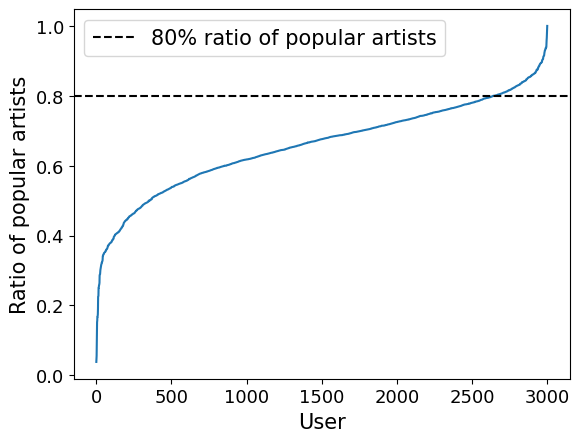

In [37]:
plt.figure()
plt.plot(sorted(pop_fraq))
plt.xlabel('User', fontsize='15')
plt.xticks(fontsize='13')
plt.ylabel('Ratio of popular artists', fontsize='15')
plt.yticks(fontsize='13')
plt.axhline(y=0.8, color='black', linestyle='--', label='80% ratio of popular artists')
plt.legend(fontsize='15')

In [38]:
print('Average LowMS profile size: ' + str(low_profile_size))
print('Average MedMS profile size: ' + str(medium_profile_size))
print('Average HighMS profile size: ' + str(high_profile_size))

Average LowMS profile size: 252.26
Average MedMS profile size: 414.317
Average HighMS profile size: 341.902


In [39]:
scaled_df_events = pd.DataFrame()
for user_id, group in df_events.groupby('user'):
    min_rating = group['count'].min()
    max_rating = group['count'].max()
    scaler = MinMaxScaler(feature_range=(1, 1000))
    scaled_ratings = scaler.fit_transform(group['count'].values.reshape(-1, 1).astype(float))
    new_rows = group.copy()
    new_rows['count'] = scaled_ratings
    scaled_df_events = scaled_df_events.append(new_rows)

scaled_df_events.head()
#scaled_df_events = scaled_df_events.set_index('user') # needed for new python/surprise version

/tmp/ipykernel_27612/2971632727.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scaled_df_events = scaled_df_events.append(new_rows)
/tmp/ipykernel_27612/2971632727.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scaled_df_events = scaled_df_events.append(new_rows)
/tmp/ipykernel_27612/2971632727.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scaled_df_events = scaled_df_events.append(new_rows)
/tmp/ipykernel_27612/2971632727.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scaled_df_events = scaled_df_events.append(new_rows)
/tmp/ipykernel_27612/2971632727.py:9: FutureWarning: The frame.append method is deprecated and w

,user,artist,count
0,1021445,12,184.222707
1,1021445,16,1.000000
2,1021445,28,27.174672
3,1021445,29,1.000000
4,1021445,46,1.000000


In [40]:
df_events = scaled_df_events
print('Min rating: ' + str(df_events['count'].min()))
print('Max rating: ' + str(df_events['count'].max()))

Min rating: 1.0
Max rating: 1000.0000000000002


In [41]:
reader = Reader(rating_scale=(df_events['count'].min(), df_events['count'].max()))
df_events.head()

,user,artist,count
0,1021445,12,184.222707
1,1021445,16,1.000000
2,1021445,28,27.174672
3,1021445,29,1.000000
4,1021445,46,1.000000


In [42]:
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_events, reader)

In [43]:
trainset, testset = train_test_split(data, test_size = 0.2, random_state = my_seed)

In [44]:
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

In [45]:
def get_top_n_random(testset, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r in testset:
        if len(top_n[uid]) == 0:
            for i in range(0, 10):
                top_n[uid].append((rd.choice(item_dist.index), i))
    return top_n


In [46]:
def get_top_n_mp(testset, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r in testset:
        if len(top_n[uid]) == 0:
            for iid, count in item_dist[:n].items():
                top_n[uid].append((iid, count))
    return top_n


In [47]:
def get_mae_of_groups(predictions):
    print('All: ')
    accuracy.mae(predictions)
    low_predictions = []
    med_predictions = []
    high_predictions = []
    for uid, iid, true_r, est, details in predictions:
        prediction = [(uid, iid, true_r, est, details)]
        if uid in low_users.index:
            low_predictions.append(accuracy.mae(prediction, verbose=False))
        elif uid in medium_users.index:
            med_predictions.append(accuracy.mae(prediction, verbose=False))
        else:
            high_predictions.append(accuracy.mae(prediction, verbose=False))
    print('LowMS: ' + str(np.mean(low_predictions)))
    print('MedMS: ' + str(np.mean(med_predictions)))
    print('HighMS: ' + str(np.mean(high_predictions)))
    print(stats.ttest_ind(low_predictions, high_predictions))

In [48]:
# create item dataframe with normalized item counts
df_item_dist = pd.DataFrame(item_dist)
df_item_dist.columns = ['count']
df_item_dist['count'] /= no_users
#df_item_dist.head()

In [49]:
sim_users = {'name': 'cosine', 'user_based': True}  # compute cosine similarities between users
algos = [] # Random and MostPopular is calculated by default
algos.append(KNNBasic(sim_options = sim_users, k=40)) 
algos.append(KNNWithMeans(sim_options = sim_users, k=40)) 
algos.append(NMF(n_factors = 15))
algo_names = [
              'UserKNN',
              'UserKNNAvg',
              'NMF']

i = 0
low_rec_gap_list = [] # one entry per algorithmus
medium_rec_gap_list = []
high_rec_gap_list = []
for i in range(0, len(algo_names)):
    df_item_dist[algo_names[i]] = 0
    low_rec_gap = 0
    medium_rec_gap = 0
    high_rec_gap = 0
    
    # get accuracy for personalized approaches
    if algo_names[i] != 'Random' and algo_names[i] != 'MostPopular':
        algos[i].fit(trainset)
        predictions = algos[i].test(testset)
        print(algo_names[i])
        get_mae_of_groups(predictions)
    
    # get top-n items and calculate gaps for all algorithms
    if algo_names[i] == 'Random':
        top_n = get_top_n_random(testset, n=10)
    elif algo_names[i] == 'MostPopular':
        top_n = get_top_n_mp(testset, n=10)
    else:
        top_n = get_top_n(predictions, n=10)
    low_count = 0
    med_count = 0
    high_count = 0
    for uid, user_ratings in top_n.items():
        iid_list = []
        for (iid, _) in user_ratings:
            df_item_dist.loc[iid, algo_names[i]] += 1
            iid_list.append(iid)
        gap = sum(item_dist[iid_list] / no_users) / len(iid_list)
        if uid in low_users.index:
            low_rec_gap += gap
            low_count += 1
        elif uid in medium_users.index:
            medium_rec_gap += gap
            med_count += 1
        elif uid in high_users.index:
            high_rec_gap += gap
            high_count += 1
    low_rec_gap_list.append(low_rec_gap / low_count)
    medium_rec_gap_list.append(medium_rec_gap / med_count)
    high_rec_gap_list.append(high_rec_gap / high_count)
    i += 1 # next algorithm

Computing the cosine similarity matrix...
Done computing similarity matrix.
UserKNN
All: 
MAE:  57.3973
LowMS: 62.08818149659613
MedMS: 54.59926385579911
HighMS: 57.35302586604718
Ttest_indResult(statistic=8.384792535800822, pvalue=5.136262982866447e-17)
Computing the cosine similarity matrix...
Done computing similarity matrix.
UserKNNAvg
All: 
MAE:  50.0875
LowMS: 55.4221705053277
MedMS: 45.17164145556182
HighMS: 52.14722885097943
Ttest_indResult(statistic=5.866824754044272, pvalue=4.453945702433029e-09)
NMF
All: 
MAE:  42.2394
LowMS: 45.47310717805423
MedMS: 37.53693963473663
HighMS: 45.58414535009883
Ttest_indResult(statistic=-0.17137742690240448, pvalue=0.863927295403461)


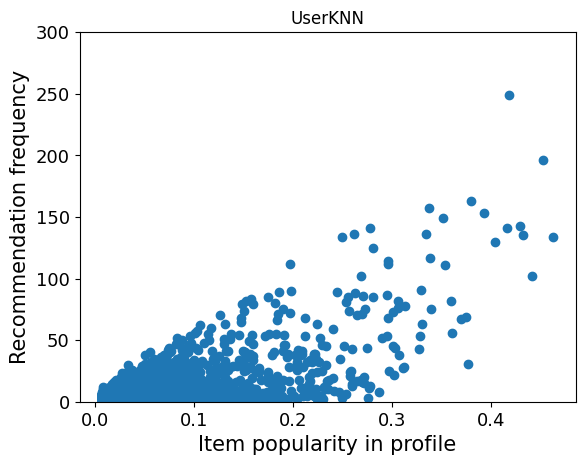

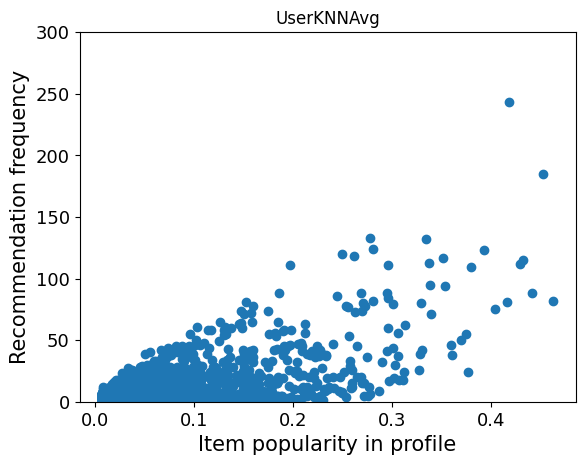

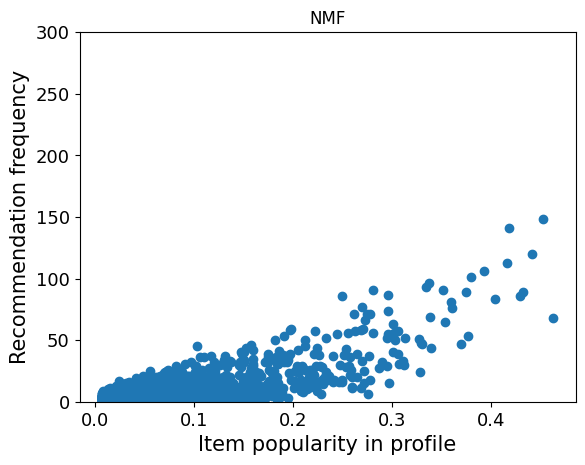

In [74]:
for i in range(0, len(algo_names)):
    plt.figure()
    x = df_item_dist['count']
    y = df_item_dist[algo_names[i]]
    plt.title(algo_names[i])
    #slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    #line = slope * np.array(x) + intercept
    #print(r_value)
    if algo_names[i] != 'Random' and algo_names[i] != 'MostPopular':
        plt.gca().set_ylim(0, 300)
    plt.plot(x, y, 'o')#, x, line)
    plt.xlabel('Item popularity in profile', fontsize='15')
    plt.ylabel('Recommendation frequency', fontsize='15')
    plt.xticks(fontsize='13')
    plt.yticks(fontsize='13')
    plt.savefig("graphs/"+algo_names[i]+"_sampled_data_results_new.png")
    plt.show()
    #plt.savefig('data/ECIR/rec_' + algo_names[i] + '.png', dpi=300, bbox_inches='tight')

In [60]:
low_gap_vals = []
medium_gap_vals = []
high_gap_vals = []

for i in range(0, len(algos)):
    low_gap_vals.append((low_rec_gap_list[i] - low_gap) / low_gap * 100)
    medium_gap_vals.append((medium_rec_gap_list[i] - medium_gap) / medium_gap * 100)
    high_gap_vals.append((high_rec_gap_list[i] - high_gap) / high_gap * 100)


In [61]:
low_gap_vals

[31.778471809282905, 19.483588804612285, 17.678690674281306]

In [62]:
medium_gap_vals

[54.620861311721406, 37.7334811119366, 20.14920193064237]

In [63]:
high_gap_vals

[51.72472195330187, 38.67421877211631, 26.362138271600116]

In [55]:
algo_names

['UserKNN', 'UserKNNAvg', 'NMF']